In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy
import pandas
import pickle
import seaborn

from sklearn import metrics

In [45]:
seaborn.set_style('white')
seaborn.set_palette('colorblind')

Experiments with embeddings
===

## Base implementation
 * loss: average mse between embedding of next exercise and network output
 * hidden_layer_size 200
 * embedding_size 200
 * log_values 50
 * logs_dirname '../results/dkt_lstm/by_problem_id/tensorboard/'
 * batch_size: 50
 * max_num_steps: 100
 * training_epochs 500

### Validation results


In [46]:
lstm_results = pandas.DataFrame([
        [50, -0.326093822718],
        [100, -0.0424702838063],
        [150, -0.0353030189872],
        [200, -0.0305649638176],
        [250, -0.0265223439783],
        [300, -0.0227521844208],
        [350, -0.019143987447],
        [400, -0.015706256032],
        [450, -0.0125677362084],
    ], columns=['iteration', 'r2'])
lstm_results['type'] = 'validation'

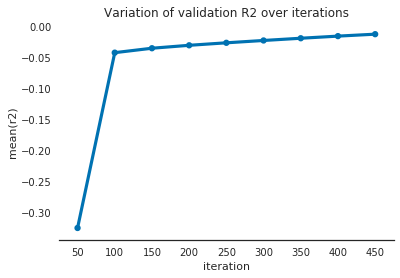

In [47]:
seaborn.pointplot(x="iteration", y="r2", data=lstm_results, markers='.', linestyles='-')
plt.title('Variation of validation R2 over iterations')
seaborn.despine(left=True)
plt.show()

### Testing results

In [48]:
test_prediction_file = '../../results/dkt_lstm/by_problem_id/predictions.p'

with open(test_prediction_file, 'r') as prediction_file:
    predictions = pickle.load(prediction_file)

In [49]:
predictions[0][:2], predictions[1][:2]

(array([ array([ 0.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  1.,  1.,  1.,  0.,  0.,  1.]),
        array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,
         0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  1.])], dtype=object),
 array([ array([ 0.89050364,  0.86510211,  0.87859803,  0.8670398 ,  0.90549248,
         0.86127472,  0.90284407,  0.89382327,  0.90859967,  0.90548432,
         0.88801014,  0.86797667,  0.86054766,  0.81209654,  0.82035303,
         0.83907199,  0.82307279,  0.86848491,  0.87063777,  0.84109551]),
        array([ 0.86051422,  0.86274099,  0.86533678,  0.84825784,  0.86659229,
         0.86330354,  0.79398513,  0.78713739,  0.85478956,  0.79756987,
         0.81610858,  0.80934018,  0.81382692,  0.80486888,  0.79771864,
         0.83418673,  0.81484979,  0.84527588,  0.87257445,  0.88396031,
         0.86977249,  0.84711796, 

#### RMSE results

In [50]:
def get_rmse(true, predicted):
    results = []
    for true_sequence, predicted_sequence in zip(true, predicted):
        results.append([metrics.mean_squared_error(true_sequence, predicted_sequence)**0.5,
                        true_sequence.shape[0]])
    return pandas.DataFrame(results, columns=['RMSE', 'Sequence lenght'])

def get_mean_rmse(true, predicted):
    all_true = numpy.concatenate(true)
    all_predicted = numpy.concatenate(predicted)
    return metrics.mean_squared_error(all_true, all_predicted)**0.5

In [51]:
get_mean_rmse(*predictions)

0.51792214915097978

In [52]:
rmse_results = get_rmse(*predictions)

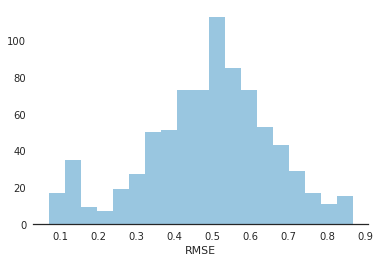

In [53]:
seaborn.distplot(rmse_results.RMSE, kde=False)
seaborn.despine(left=True)

In [54]:
rmse_results.describe()

,RMSE,Sequence lenght
count,800.000000,800.000000
mean,0.489896,78.107500
std,0.166966,163.339051
min,0.069897,1.000000
25%,0.395730,8.000000
50%,0.513634,21.000000
75%,0.598364,64.250000
max,0.867986,1261.000000


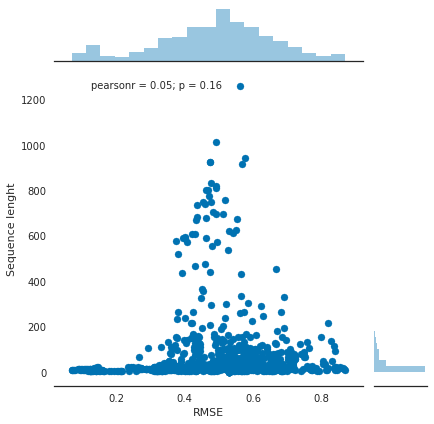

In [55]:
seaborn.jointplot(x='RMSE', y='Sequence lenght', data=rmse_results)
seaborn.despine(left=True)

#### AUC results

In [56]:
def get_auc_roc_curve(true, predicted):
    results = []
    ignored_sequences = 0
    for true_sequence, predicted_sequence in zip(true, predicted):
        try:
            results.append([metrics.roc_auc_score(true_sequence, predicted_sequence),
                            true_sequence.shape[0]])
        except ValueError:
            ignored_sequences += 1
    print '{} sequences with only one class, ignoring.'.format(ignored_sequences)
    return pandas.DataFrame(results, columns=['AUC', 'Sequence lenght'])

def get_mean_auc_roc_curve(true, predicted):
    all_true = numpy.concatenate(true)
    all_predicted = numpy.concatenate(predicted)
    return metrics.roc_auc_score(all_true, all_predicted)

In [57]:
aucs = get_auc_roc_curve(*predictions)

111 sequences with only one class, ignoring.


In [58]:
aucs.describe()

,AUC,Sequence lenght
count,689.000000,689.000000
mean,0.209416,89.876633
std,0.249353,173.151829
min,0.000000,2.000000
25%,0.047619,12.000000
50%,0.108851,26.000000
75%,0.269231,80.000000
max,1.000000,1261.000000


In [59]:
get_mean_auc_roc_curve(*predictions)

0.12763605192678026

#### R2 results

In [60]:
def get_r2(true, predicted):
    results = []
    for true_sequence, predicted_sequence in zip(true, predicted):
        results.append([metrics.r2_score(true_sequence, predicted_sequence),
                        true_sequence.shape[0]])
    return pandas.DataFrame(results, columns=['R2', 'Sequence lenght'])

def get_mean_r2(true, predicted):
    all_true = numpy.concatenate(true)
    all_predicted = numpy.concatenate(predicted)
    return metrics.r2_score(all_true, all_predicted)

In [61]:
get_mean_r2(*predictions)

-0.211390168048323

In [62]:
r2s = get_r2(*predictions)
r2s.describe()

,R2,Sequence lenght
count,800.000000,800.000000
mean,-0.568023,78.107500
std,1.534304,163.339051
min,-15.975795,1.000000
25%,-0.448248,8.000000
50%,-0.189086,21.000000
75%,-0.075918,64.250000
max,0.091151,1261.000000


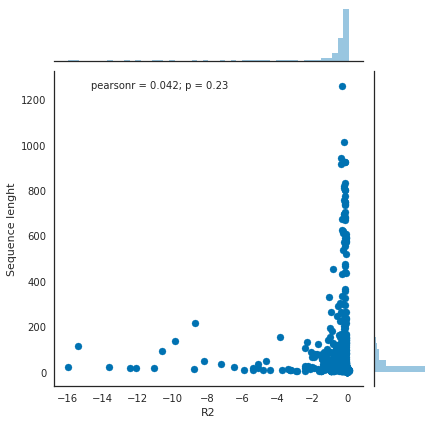

In [63]:
seaborn.jointplot(x='R2', y='Sequence lenght', data=r2s)

---

## Loss2

In [26]:
test_prediction_file = '../../results/dkt_lstm/by_problem_id/loss2/predictions.p'

with open(test_prediction_file, 'r') as prediction_file:
    predictions = pickle.load(prediction_file)

In [27]:
predictions[0][:2], predictions[1][:2]

(array([ array([ 1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,
         1.,  0.,  0.,  1.,  1.,  1.,  1.]),
        array([ 0.,  1.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,  1.])], dtype=object),
 array([ array([ 6.90831709,  6.90310478,  6.90170479,  6.91735411,  6.90674305,
         6.91572857,  6.9174881 ,  6.91352987,  6.90544891,  6.92284298,
         6.9186058 ,  6.90685225,  6.91456127,  6.91244268,  6.92584848,
         6.90706778,  6.91104698,  6.90666676,  6.91724157,  6.92098045,
         6.91334391,  6.91187668,  6.92582607,  6.90050793,  6.91416025,
         6.90985203,  6.90830421,  6.92505217,  6.91651106,  6.92109346,
         6.92092991,  6.91731787,  6.9

In [22]:
def get_rmse(true, predicted):
    results = []
    for true_sequence, predicted_sequence in zip(true, predicted):
        results.append([metrics.mean_squared_error(true_sequence, 1-predicted_sequence)**0.5,
                        true_sequence.shape[0]])
    return pandas.DataFrame(results, columns=['RMSE', 'Sequence lenght'])

In [23]:
rmse_results = get_rmse(*predictions)

In [ ]:
seaborn.distplot(rmse_results.RMSE, kde=False)
seaborn.despine(left=True)

In [24]:
rmse_results.describe()

,RMSE,Sequence lenght
count,800.000000,800.000000
mean,6.132072,72.640000
std,0.320483,150.521489
min,5.233535,1.000000
25%,5.989028,8.000000
50%,6.166323,21.000000
75%,6.331806,58.000000
max,6.866883,1094.000000
